### [1] 패키지 불러오기

In [16]:
import os
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
import timm
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from PIL import Image
import torchvision.transforms as transforms
from PIL import Image

### [2] Data transform 정의

In [17]:
import torchvision.transforms as transforms

# 사이즈 설정
size = [230, 230]
center_size = [224, 224]

# 학습용 Transform
TrainTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 검증/테스트용 Transform
ValidTransform = transforms.Compose([
    transforms.Resize(size),
    transforms.CenterCrop(center_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


### [3] Eye dataset 클래스

In [55]:
import os
import json
from PIL import Image
import torch
from torch.utils.data import Dataset

class RightEyeDataset(Dataset):
    def __init__(self, data, image_path, transform=None):
        self.data = data
        self.image_path = image_path
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        right_img = Image.open(os.path.join(self.image_path, item['right_eye'])).convert('RGB')
        if self.transform:
            right_img = self.transform(right_img)
        label = torch.tensor(item['label'], dtype=torch.long)
        return right_img, label

    @classmethod
    def from_json(cls, json_file, image_path, group_value=1, transform=None):
        with open(json_file, 'r') as f:
            raw_data = json.load(f)

        usable_data = [
            item for item in raw_data.values()
            if item.get('group') == group_value and item.get('right_eye') is not None
        ]

        print(f"usable samples for group {group_value}: {len(usable_data)}")
        return cls(usable_data, image_path, transform)


### [4] 구글 드라이브 연동

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### [5] train_loader, val_loader, test_loader 구성

In [56]:
from torch.utils.data import DataLoader

# 경로 설정
json_path = '/content/drive/MyDrive/cv_project/dataset/data_info.json'
image_path = '/content/drive/MyDrive/cv_project/dataset/train_images/Fundus_CIMT_2903 Dataset'

# 데이터셋 생성
train_dataset = RightEyeDataset.from_json(
    json_file=json_path, image_path=image_path, group_value=1, transform=TrainTransform)

val_dataset = RightEyeDataset.from_json(
    json_file=json_path, image_path=image_path, group_value=2, transform=ValidTransform)

test_dataset = RightEyeDataset.from_json(
    json_file=json_path, image_path=image_path, group_value=3, transform=ValidTransform)

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2, pin_memory=True)


usable samples for group 1: 2603
usable samples for group 2: 200
usable samples for group 3: 100


### [6] SiameseSeResNeXtdropout 모델 정의

In [57]:
class RightEyeClassifier(nn.Module):
    def __init__(self, dropout_p=0.3):
        super(RightEyeClassifier, self).__init__()
        self.backbone = timm.create_model('tf_efficientnetv2_s.in1k', pretrained=True, num_classes=0)
        self.dropout = nn.Dropout(dropout_p)

        self.classifier = nn.Sequential(
            nn.Linear(1280, 512),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        feat = self.backbone(x)         # (B, 1280)
        feat = self.dropout(feat)
        out = self.classifier(feat)     # (B, 2)
        return out


### [7] FocalLoss 클래스 정의

In [58]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha  # scalar or list (optional)
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')  # [B]
        pt = torch.exp(-ce_loss)  # [B]
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss  # [B]

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


### [8] 학습 루프

In [59]:
import torch.nn.functional as F
from torch import nn, optim
from torch.optim import lr_scheduler

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 손실 함수
criterion_cls = FocalLoss()

# 모델 초기화 (오른쪽 눈만 사용)
model = RightEyeClassifier(dropout_p=0.3).to(device)

# 옵티마이저 및 스케줄러
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

# 학습 설정
epochs = 20
best_val_loss = float('inf')

train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion_cls(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion_cls(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    scheduler.step()

    # Best 모델 저장
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/cv_project/01unimodal/best_right_cls_model.pth')
        print(f"Best model updated at epoch {epoch+1} (Val Loss: {best_val_loss:.4f})")

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Val Acc: {val_accuracy:.4f} | LR: {scheduler.get_last_lr()[0]:.6f}")


Best model updated at epoch 1 (Val Loss: 0.1605)
Epoch 1/20 | Train Loss: 0.1438 | Val Loss: 0.1605 | Val Acc: 0.6800 | LR: 0.001000
Epoch 2/20 | Train Loss: 0.1296 | Val Loss: 0.2129 | Val Acc: 0.5700 | LR: 0.001000
Epoch 3/20 | Train Loss: 0.1265 | Val Loss: 0.2035 | Val Acc: 0.6900 | LR: 0.001000
Best model updated at epoch 4 (Val Loss: 0.1547)
Epoch 4/20 | Train Loss: 0.1235 | Val Loss: 0.1547 | Val Acc: 0.7250 | LR: 0.001000
Epoch 5/20 | Train Loss: 0.1260 | Val Loss: 0.1752 | Val Acc: 0.6500 | LR: 0.001000
Epoch 6/20 | Train Loss: 0.1230 | Val Loss: 0.1573 | Val Acc: 0.7350 | LR: 0.001000
Epoch 7/20 | Train Loss: 0.1228 | Val Loss: 0.1702 | Val Acc: 0.6900 | LR: 0.001000
Epoch 8/20 | Train Loss: 0.1203 | Val Loss: 0.1650 | Val Acc: 0.6850 | LR: 0.001000
Epoch 9/20 | Train Loss: 0.1210 | Val Loss: 0.1920 | Val Acc: 0.6900 | LR: 0.001000
Epoch 10/20 | Train Loss: 0.1216 | Val Loss: 0.1919 | Val Acc: 0.6350 | LR: 0.001000
Epoch 11/20 | Train Loss: 0.1197 | Val Loss: 0.1778 | Val Acc

### [9] 손실 json 파일 저장

In [60]:
import json

# 저장할 경로
save_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_right_cls_model.json'

# 저장할 손실 딕셔너리
loss_history = {
    'train_loss': train_losses,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies
}

# JSON 저장
with open(save_path, 'w') as f:
    json.dump(loss_history, f, indent=2)

print("loss_history_right_cls_model.json 저장 완료!")


loss_history_right_cls_model.json 저장 완료!


### [10] loss 그래프

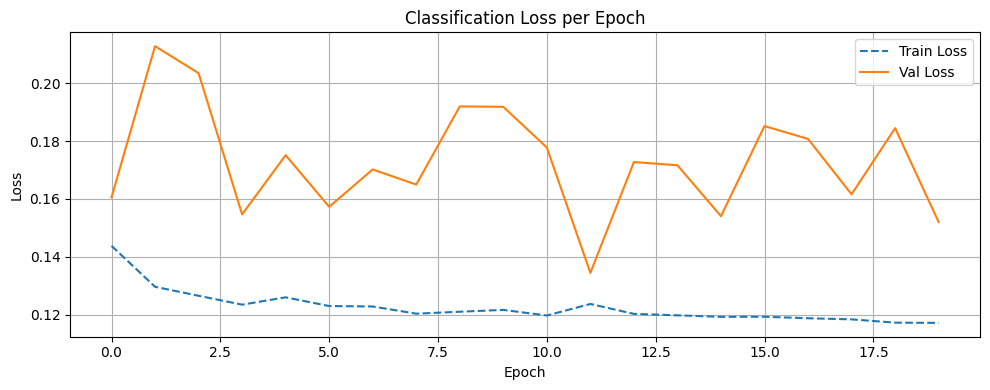

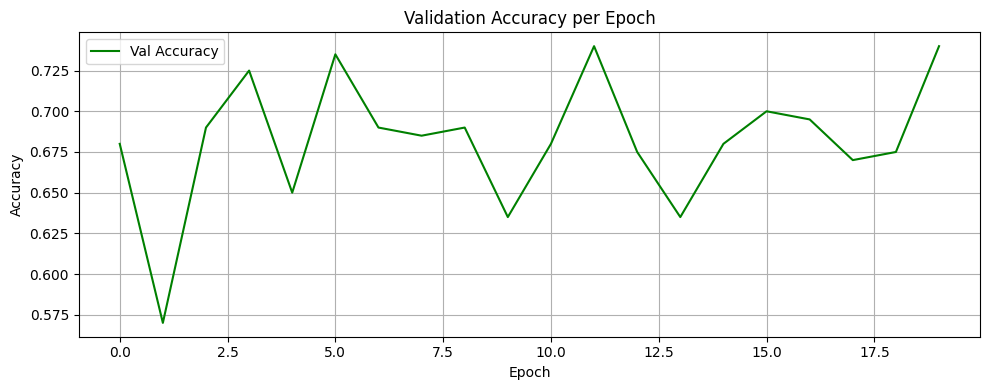

In [61]:
import json
import matplotlib.pyplot as plt

# JSON 불러오기
load_path = '/content/drive/MyDrive/cv_project/01unimodal/loss_history_right_cls_model.json'

with open(load_path, 'r') as f:
    loss_history = json.load(f)

# 리스트 추출
train_losses = loss_history['train_loss']
val_losses = loss_history['val_loss']
val_accuracies = loss_history['val_accuracy']

# 손실 그래프
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss', linestyle='--')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Classification Loss per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 정확도 그래프
plt.figure(figsize=(10, 4))
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### [11] 예측 수행

In [63]:
from tqdm import tqdm
import json
import torch

# 모델 로드
model = RightEyeClassifier(dropout_p=0.3).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/cv_project/01unimodal/best_right_cls_model.pth'))
model.eval()

# 예측 수행
results = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Predicting"):
        images = images.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        for true, pred, prob in zip(labels.cpu(), preds.cpu(), probs[:, 1].cpu()):
            results.append({
                "true_label": int(true.item()),
                "pred_label": int(pred.item()),
                "prob_thickened": float(prob.item())  # class 1 (고위험군) 확률
            })

# 결과 저장
output_path = "/content/drive/MyDrive/cv_project/01unimodal/predict_result_right_cls_model.json"
with open(output_path, "w") as f:
    json.dump(results, f, indent=2)

print(f"예측 결과 저장 완료: {output_path}")


Predicting: 100%|██████████| 7/7 [00:01<00:00,  6.97it/s]

예측 결과 저장 완료: /content/drive/MyDrive/cv_project/01unimodal/predict_result_right_cls_model.json


### [12] 평가

[Classification Evaluation]
정확도 (Accuracy): 0.7500
AUC-ROC: 0.8552

분류 리포트:
              precision    recall  f1-score   support

      Normal       0.80      0.66      0.73        50
   Thickened       0.71      0.84      0.77        50

    accuracy                           0.75       100
   macro avg       0.76      0.75      0.75       100
weighted avg       0.76      0.75      0.75       100

Confusion Matrix:
[[33 17]
 [ 8 42]]


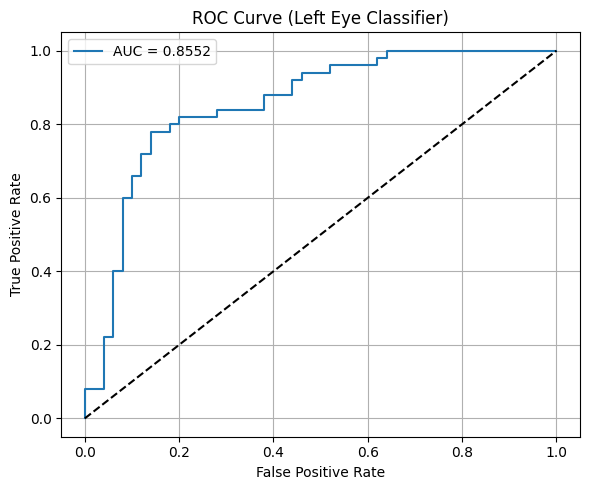

In [64]:
import json
import numpy as np
from sklearn.metrics import (
    roc_curve, roc_auc_score, classification_report, confusion_matrix
)
import matplotlib.pyplot as plt

# 예측 결과 불러오기
with open("/content/drive/MyDrive/cv_project/01unimodal/predict_result_right_cls_model.json", "r") as f:
    results = json.load(f)

# 분류 관련 데이터 추출
y_true = [r["true_label"] for r in results]
y_pred = [r["pred_label"] for r in results]
y_prob = [r["prob_thickened"] for r in results]

# === 분류 평가 === #
fpr, tpr, _ = roc_curve(y_true, y_prob)
auc_score = roc_auc_score(y_true, y_prob)
accuracy = np.mean(np.array(y_true) == np.array(y_pred))

print("[Classification Evaluation]")
print(f"정확도 (Accuracy): {accuracy:.4f}")
print(f"AUC-ROC: {auc_score:.4f}")
print("\n분류 리포트:")
print(classification_report(y_true, y_pred, target_names=["Normal", "Thickened"]))
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

# === ROC Curve === #
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Left Eye Classifier)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
